In [ ]:
import kagglehub
meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path = kagglehub.dataset_download('meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')

print('Data source path: ' + meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path)

Data source path: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [ ]:
data_dir = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
test_path = '/kaggle/input/gtsrb-german-traffic-sign/Test'
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))
print(NUM_CATEGORIES)

43


In [ ]:
class_names = [
    "speed limit 20 (prohibitory)",
    "speed limit 30 (prohibitory)",
    "speed limit 50 (prohibitory)",
    "speed limit 60 (prohibitory)",
    "speed limit 70 (prohibitory)",
    "speed limit 80 (prohibitory)",
    "restriction ends 80 (other)",
    "speed limit 100 (prohibitory)",
    "speed limit 120 (prohibitory)",
    "no overtaking (prohibitory)",
    "no overtaking (trucks) (prohibitory)",
    "priority at next intersection (danger)",
    "priority road (other)",
    "give way (other)",
    "stop (other)",
    "no traffic both ways (prohibitory)",
    "no trucks (prohibitory)",
    "no entry (other)",
    "danger (danger)",
    "bend left (danger)",
    "bend right (danger)",
    "bend (danger)",
    "uneven road (danger)",
    "slippery road (danger)",
    "road narrows (danger)",
    "construction (danger)",
    "traffic signal (danger)",
    "pedestrian crossing (danger)",
    "school crossing (danger)",
    "cycles crossing (danger)",
    "snow (danger)",
    "animals (danger)",
    "restriction ends (other)",
    "go right (mandatory)",
    "go left (mandatory)",
    "go straight (mandatory)",
    "go right or straight (mandatory)",
    "go left or straight (mandatory)",
    "keep right (mandatory)",
    "keep left (mandatory)",
    "roundabout (mandatory)",
    "restriction ends (overtaking) (other)",
    "restriction ends (overtaking (trucks)) (other)"
]


In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error")

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
lr = 0.001
epochs = 50

opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=3)

history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_reduce]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.4019 - loss: 2.6402 - val_accuracy: 0.9373 - val_loss: 0.2273 - learning_rate: 0.0010
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8702 - loss: 0.4171 - val_accuracy: 0.9858 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9366 - loss: 0.2119 - val_accuracy: 0.9801 - val_loss: 0.0577 - learning_rate: 0.0010
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9508 - loss: 0.1590 - val_accuracy: 0.9868 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9575 - loss: 0.1458 - val_accuracy: 0.9919 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9641 - loss: 0.1244 - val_accuracy: 0.9952 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9687 - l

In [ ]:

y_pred_probs = model.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)


858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


Accuracy on Training Set: 100.00%


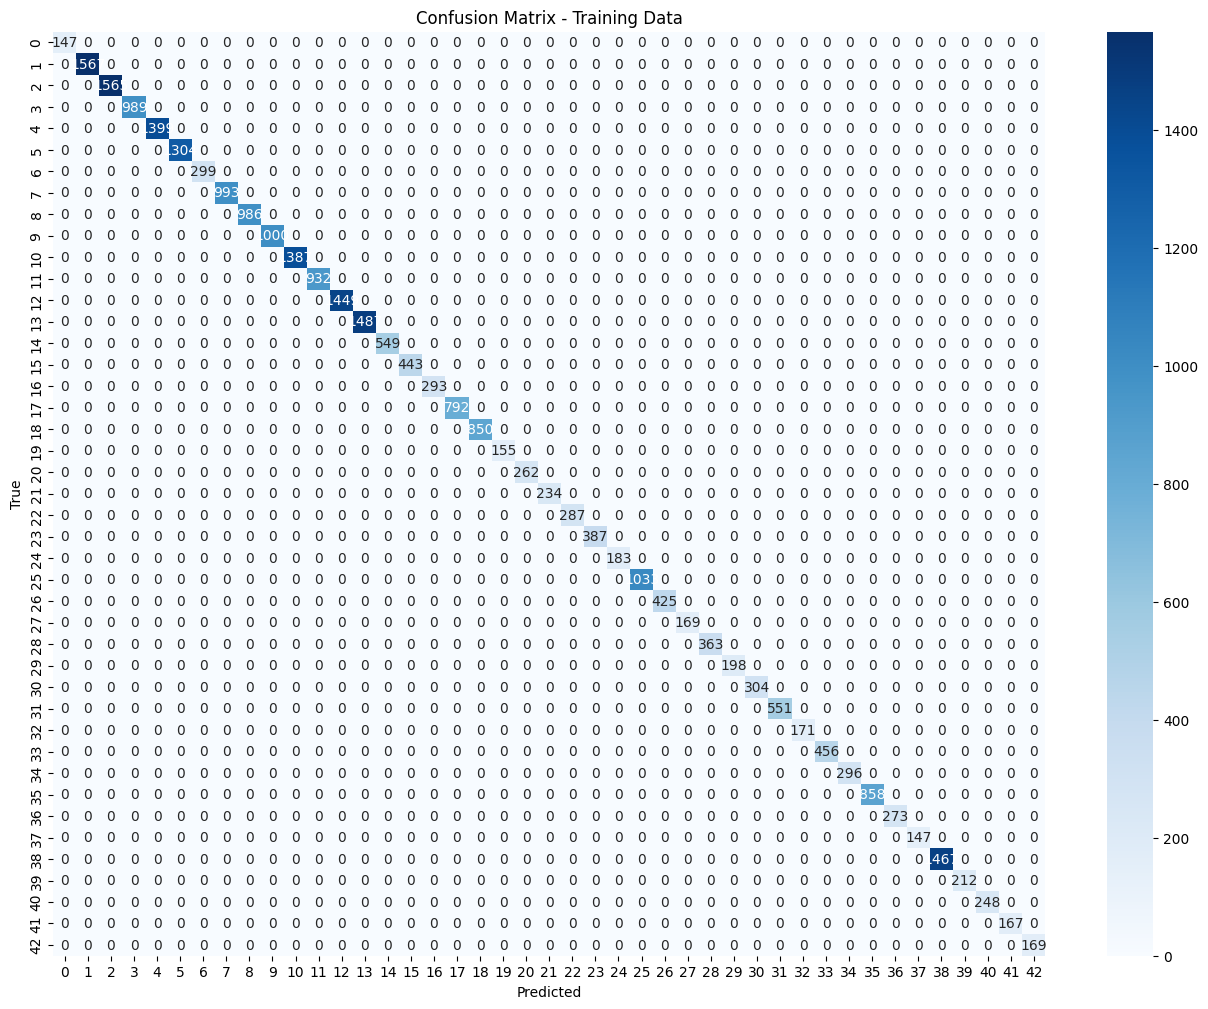

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on Training Set: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot = True, cmap="Blues", fmt = "d", cbar = True)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [ ]:

y_pred_probs1 = model.predict(X_val)
y_pred1 = np.argmax(y_pred_probs1, axis=1)
y_true1 = np.argmax(y_val, axis=1)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_true1, y_pred1)
print(f"Accuracy on Training Set: {accuracy * 100:.2f}%")

368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy on Training Set: 99.97%


In [ ]:
model.save("cnn_final_model_endterm.h5")
